# Getting Started with Numba

Numba is a just in time (JIT) compiler for Python and NumPy code.  From their website:

>Numba translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library. Numba-compiled numerical algorithms in Python can approach the speeds of C or FORTRAN.

In this getting-started guide, we compare the performance of different combinations of Numba and NumPy and briefly discuss using this approach on Eagle.  For more Numba background and performance options, you're encouraged to review the following extremely helpful links:

- [A ~5 minute guide to Numba](https://numba.readthedocs.io/en/stable/user/5minguide.html)
- [Performance Tips](https://numba.readthedocs.io/en/stable/user/performance-tips.html#performance-tips)

### Building a Numba Environemt

In order to run this notebook, you'll need to build a minimal Conda environment with the Numba, Matplotlib, and Jupyter packages as shown below

    conda create -n numba-env numba matplotlib jupyter
    
Follow the prompts to download the necessary packages and when installation has finished, activate the environment with

    conda activate numba-env
    
Once activated, you should be able to execute the cell below without error

In [1]:
%reset -f
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

### Testing Numba Compilation Speedup

With a working environment for testing built, we move on to testing the performance of Numba and experimenting with a common use option using an example that appears frequently in numerical methods: calculating Euclidean distances between points in 3D space.  We assume that `position` is an array of floating-point values with $N$ rows and 3 columns, where the $k$th row represents point $k$'s x-, y-, and z-position.  The first approach to this problem is shown in function `calc_all_distances`.  It represents a naive but workable first attempt at solving a problem like this, using a double for loop to consider each pair-wise interaction (note that it does not exclude comparing a point with itself, i.e., when `k=j`).

In [2]:
def calc_all_distances(position):
    num_points = np.shape(position)[0]
    
    distance = np.zeros((num_points, num_points))
    
    for k in range(num_points):
        for j in range(num_points):
            # Calculate the separation in the x, y, and z-directions
            dx = position[k, :] - position[j, :]

            # Compute the Euclidean between particle "k" and "j"
            distance[k, j] = np.sqrt(dx[0]**2 + dx[1]**2 + dx[2]**2)
    
    return distance

This version of the function is quick to write and easy to understand, but after some thought, a natural next step might be to remove the inner loop and replace it with a vectorized operation which compares a single point `k` with all its possible pairs from the range `j=1:N`.  This semi-vectorized function still retains good readability, and allowing NumPy to compute all the interactions at once using the library's highly-efficient operations should improve the execution speed.

In [3]:
def semi_vectorized_calc_all_distances(position):
    num_points = np.shape(position)[0]
    
    distance = np.zeros((num_points, num_points))
    
    for k in range(num_points):
        dx = position[k, :] - position[:, :]
        
        distance[k, :] = np.sqrt(dx[:, 0]**2 + dx[:, 1]**2 + dx[:, 2]**2)
            
    return distance

To squeeze even more performance from this function, we can construct a version of this problem that allows us to remove even the outer loop such that *all* interactions between *all* pairs are calculated in a few fully-vecorized lines.  Here, the readability is significantly diminished (at first glance, it's not obvious what this function does) but the hope is that it more than makes up for its algorithmic density with execution speed.

In [4]:
def fully_vectorized_calc_all_distances(position):
    
    num_points = np.shape(position)[0]
    
    dx = np.reshape(position, (1, -1)) - np.tile(position, (1, num_points))
    
    distance = np.sqrt(dx[:, 0::3]**2 + dx[:, 1::3]**2 + dx[:, 2::3]**2)
            
    return distance

Thus far, we haven't done any compilation with Numba, simply produced some different approaches to the same problem.  The last approach we'll use is a carbon-copy of the first implementation, `calc_all_distances`, using a nested loop.  The only change is that we've added a decorator to tell Numba to compile this function when it's first called and then execute the compiled version which contains optimizations and efficiency improvements specific to your machine.

In [5]:
@jit(nopython=True)
def numba_calc_all_distances(position):
    num_points = np.shape(position)[0]
    
    distance = np.zeros((num_points, num_points))
    
    for k in range(num_points):
        for j in range(num_points):
            dx = position[k, :] - position[j, :]

            distance[k, j] = np.sqrt(dx[0]**2 + dx[1]**2 + dx[2]**2)
            
    return distance

### Performance Results

To compare the performance of each function, we use the `timeit` command to evaluate each function's average execution time over multiple runs consisting of 100 random points in 3D space.

In [6]:
# Create N Points randomly
N = 100
pos = np.random.rand(N, 3)

# Initialize a timing-statistics variable
timeit_list = [0, 0, 0, 0]

# Call each method while recording timing statistics
print('Running naive distance calculation...')
timeit_list[0] = %timeit -o calc_all_distances(pos)
print()

print('Running semi-vectorized distance calculation...')
timeit_list[1] = %timeit -o semi_vectorized_calc_all_distances(pos)
print()

print('Running fully-vectorized distance calculation...')
timeit_list[2] = %timeit -o fully_vectorized_calc_all_distances(pos)
print()

print('Running Numba-compiled distance calculation...')
timeit_list[3] = %timeit -o numba_calc_all_distances(pos)
print()

Running naive distance calculation...
32.6 ms ± 920 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Running semi-vectorized distance calculation...
707 µs ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Running fully-vectorized distance calculation...
96.2 µs ± 3.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Running Numba-compiled distance calculation...
1.31 ms ± 58.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)



Visualizing the results in a bar plot makes these relationships clearer.

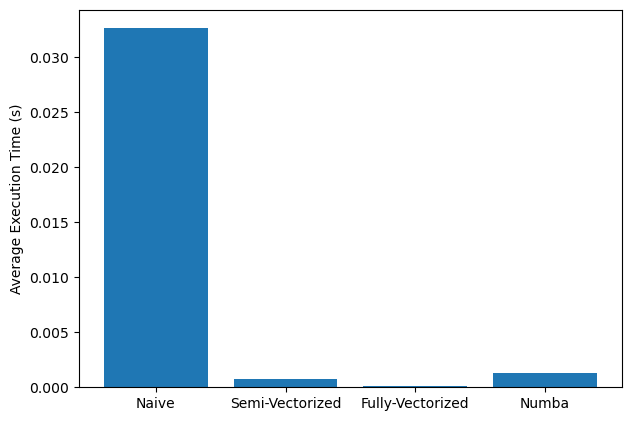

In [7]:
# Format the timing results for plotting
timing = [tt.average for tt in timeit_list]
xpts = range(len(timing))

# Plot the results
plt.figure(figsize=(7, 5), dpi=100)
plt.bar(xpts, timing)
plt.xticks(xpts, ('Naive', 'Semi-Vectorized', 'Fully-Vectorized', 'Numba'))
plt.ylabel('Average Execution Time (s)')
plt.show()

### Interpretation

Clearly the Numba-compiled function is significantly faster than its non-compiled counterpart which, as a reminder, uses the exact same double-loop algorithm to compute each separation distance.  Both the uncompiled semi-vectorized and fully-vectorized functions offer additional performance benefits, highlighting that when possible, better performance may still be obtained simply by changing the algorithmic approach.  However, it's important to stress that it may not always be possible (or easy) to implement a vectorized solution for a given problem.  Suppose each pariwise interaction in this simple function had a rigorous collision test, additional dimensions, a complex property lookup table, or other complicating factors.  Vecotrizing such a calculation might be quite challenging and would almost certainly hurt the overall readability of the code.

There will also be scenarios where vectorization of a given approach is impossible.  Consider the solution of a simple time-varying ordinary differential equation solved using the forward Euler method.  Given the initial value of the solution, the discretization returns the solution at time $t = \Delta t$, uses this value to compute the solution at time $t = 2\Delta t$, and so on.  With this method, a simple vectorization is not possible, but Numba still enables an order-of-magnitude faster simulation.

### What Types of Functions will See Improvement?

Unfortunately, adding Numba compilation is not a guarantee of attaining near-compiled speed.   Accoring to their documentation

>If your code is numerically orientated (does a lot of math), uses NumPy a lot and/or has a lot of loops, then Numba is often a good choice.

You are encouraged to read through some of the [official performance tips](https://numba.pydata.org/numba-doc/latest/user/performance-tips.html) to get a sense for what things will compile well and what functions may not show appreciable speedup.  For these real-world cases, a hybrid approach of compiling as many of the low-level, numerical portions of your algorithm as possible while leaving higher-order interactions with objects or other Python structures uncompiled may yield the best, easily-attainable performance boost.

In [ ]:
# Try it out!

@jit(nopython=True)
def new_function():
    pass
